# Dataset Iris

Este notebook implementa um pipeline de classificação multiclasse usando uma rede neural construída com JAX. O modelo serve como uma validação fundamental da nossa biblioteca ann.py, buscando classificar espécies de flores do gênero Íris com base em suas características de pétala e sépala.

Fonte do Dataset: [Iris on Kaggle](https://www.kaggle.com/datasets/uciml/iris)

## Importação de bibliotecas

- `jax.numpy` para operações vetorizadas com JAX.
- `matplotlib.pyplot` e `seaborn` para visualizações.
- `pandas` para manipulação de dados.
- `train_test_split` para particionar dados.
- `ann` para funções de rede neural.

In [1]:
import pandas as pd
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import ann

In [2]:
def codificar_rotulos_texto(rotulos_texto: pd.Series) -> tuple[jnp.ndarray, dict]:
    """
    Converte rótulos de texto para inteiros e retorna o mapa de classes.
    """
    classes_unicas = list(rotulos_texto.unique())
    mapa_classes = {i: nome for i, nome in enumerate(classes_unicas)}
    rotulos_inteiros = rotulos_texto.map({nome: i for i, nome in mapa_classes.items()})
    return jnp.array(rotulos_inteiros.values), mapa_classes

## Carregamento e preparação dos dados

Carregamos o iris.csv e, em seguida, o separamos em duas matrizes distintas:
- X (Features): As quatro colunas com as medidas das flores (comprimento e largura de pétalas e sépalas). Estas são as características que o modelo usará para aprender.
- y (Alvo/Rótulo): A coluna Species, que contém a classe que queremos que o modelo aprenda a prever.

In [3]:
df = pd.read_csv('../datasets/iris.csv')

df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
X_df = df.drop(columns=['Id', 'Species'])
y_texto = df['Species']

print("Features (X):")
print(X_df.head(2))
print("\nRótulos (y):")
print(y_texto.head(2))

Features (X):
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            5.1           3.5            1.4           0.2
1            4.9           3.0            1.4           0.2

Rótulos (y):
0    Iris-setosa
1    Iris-setosa
Name: Species, dtype: object


## Pré-processamento
- Normalização de X: As features são colocadas na mesma escala (entre 0 e 1) usando a técnica Min-Max. 
- Codificação de y: O rótulo y passa pela nossa função auxiliar para ser convertido em inteiros e, em seguida, pela função ann.codificar_one_hot.

In [5]:
X = X_df.values.T
X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X_norm = (X - X_min) / (X_max - X_min + 1e-8)

y_inteiros, mapa_classes = codificar_rotulos_texto(y_texto)
n_classes = len(mapa_classes)
y_one_hot = ann.codificar_one_hot(y_inteiros, n_classes)

print(f"Número de classes: {n_classes}")
print(f"Mapeamento de classes: {mapa_classes}")
print(f"\nShape de X normalizado: {X_norm.shape}")
print(f"Shape de y em one-hot: {y_one_hot.shape}")

Número de classes: 3
Mapeamento de classes: {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

Shape de X normalizado: (4, 150)
Shape de y em one-hot: (3, 150)


## Divisão treino-teste
- 80% dos dados para treino e 20% para teste.
- Usa `train_test_split` com `random_state=42` para reprodutibilidade.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm.T, 
    y_one_hot.T, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_inteiros
)

X_train, X_test = jnp.array(X_train.T), jnp.array(X_test.T)
y_train, y_test = jnp.array(y_train.T), jnp.array(y_test.T)

print("Shapes após a divisão:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

Shapes após a divisão:
X_train: (4, 120), y_train: (3, 120)
X_test:  (4, 30), y_test:  (3, 30)


## Treinamento da rede neural

- Arquitetura: Entrada → 10 neurônios ocultos → 8 neurônios ocultos → 3 saídas.
- Ativação oculta: ReLU
- Ativação de saída: Softmax
- Função de erro: Erro Categorial Cruzado
- Taxa de aprendizado: 0.1
- Número de épocas: 1000

In [7]:
print("--- Iniciando Treinamento da Rede Neural ---")
camadas = [X_train.shape[0], 10, 8, n_classes]

parametros_treinados = ann.treinar_rede(
    matriz_entrada=X_train,
    matriz_rotulos=y_train,
    dimensoes_camadas=camadas,
    nome_ativacao_oculta="relu",
    nome_ativacao_saida="softmax",
    nome_funcao_erro="erro_categorial_cruzado",
    taxa_aprendizado=0.1,
    numero_epocas=1000,
    verbose=True,
)
print("--- Treinamento Concluído ---")

--- Iniciando Treinamento da Rede Neural ---
Época  100/1000 - erro: 0.571009
Época  200/1000 - erro: 0.389467
Época  300/1000 - erro: 0.280276
Época  400/1000 - erro: 0.197679
Época  500/1000 - erro: 0.140034
Época  600/1000 - erro: 0.103747
Época  700/1000 - erro: 0.082845
Época  800/1000 - erro: 0.070933
Época  900/1000 - erro: 0.063746
Época 1000/1000 - erro: 0.059008
--- Treinamento Concluído ---


## Predição
- Gera previsões para treino e teste.

In [8]:
y_pred_test = ann.prever(
    X_test, 
    parametros_treinados, 
    nome_ativacao_oculta="relu", 
    nome_ativacao_saida="softmax"
)

print("Previsões realizadas no conjunto de teste.")
print(f"Primeiras 10 previsões: {y_pred_test[:10]}")

Previsões realizadas no conjunto de teste.
Primeiras 10 previsões: [0 2 1 1 0 1 0 0 2 1]


## Avaliação de desempenho

In [9]:
y_test_inteiros = jnp.argmax(y_test, axis=0)

print("--- Avaliação do Modelo no Conjunto de Teste ---")
acuracia = accuracy_score(y_test_inteiros, y_pred_test)
print(f"\nAcurácia: {acuracia:.2%}") # Formata como porcentagem

print("\nRelatório de Classificação:")
print(classification_report(y_test_inteiros, y_pred_test, target_names=mapa_classes.values()))

--- Avaliação do Modelo no Conjunto de Teste ---

Acurácia: 96.67%

Relatório de Classificação:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



## Análise Visual: Matriz de Confusão

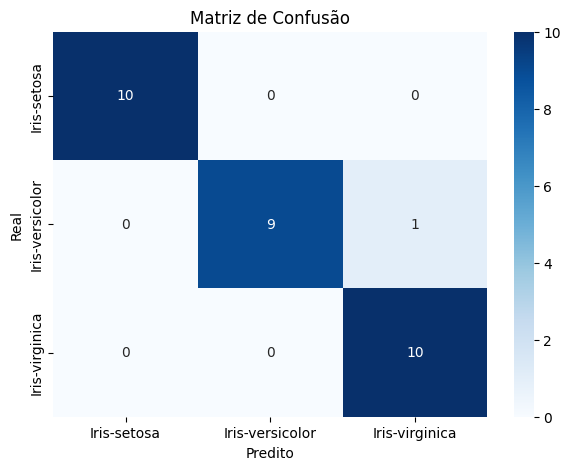

In [10]:
cm = confusion_matrix(y_test_inteiros, y_pred_test)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=mapa_classes.values(), 
            yticklabels=mapa_classes.values())
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()